# SIS model on a not-so-small random graph
Comparison with Soft Margin montecarlo

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Plots, Statistics, ProgressMeter, Random
ProgressMeter.ijulia_behavior(:clear)
using JLD2
import Measurements: value;

In [2]:
T = 10
N = 23
seed = 1

# k = 4
# gg = random_regular_graph(N, k; seed)
c = 4
gg = erdos_renyi(N, c/N; seed)
g = IndexedGraph(gg)
λ = 0.15
ρ = 0.12
γ = 0.13

sis = SIS(g, λ, ρ, T; γ);

In [3]:
bp = mpbp(sis)
cb = CB_BP(bp)
rng = MersenneTwister(seed)
nobs = N÷2
x, observed = draw_node_observations!(bp, nobs; last_time=true, softinf=1e2, rng)
observed_sites = [ob[1] for ob in observed];

In [4]:
svd_trunc = TruncBond(3)
iters, cb = iterate!(bp, maxiter=200; svd_trunc, cb, tol=1e-12)
b_bp = beliefs(bp)
p_bp = [[bᵗ[INFECTIOUS] for bᵗ in bb] for bb in b_bp];

Running MPBP: iter 36    Time: 0:00:46
  Δ:                9.79216707719388e-13


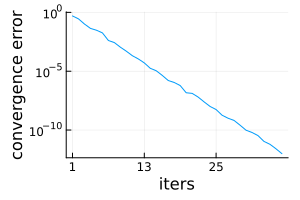

In [5]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

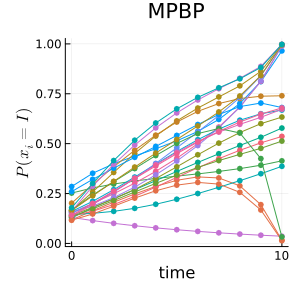

In [6]:
pl_bp = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:10:T, title="MPBP")
for i in 1:N
    plot!(pl_bp, 0:T, p_bp[i], label="i=$i", m=:o, ms=3, lw=1, markerstrokecolor=:auto)
end
plot(pl_bp, legend=false, size=(300,300))

In [7]:
# instantiate Soft Margin sampler
sms = SoftMarginSampler(bp);

In [16]:
# draw samples
# re-run this cell (but not the one above!) to draw more samples and refine the estimate
ns = 10^7
sample!(sms, ns)
b_mc = marginals(sms)
p_mc = [[bbb[INFECTIOUS] for bbb in bb] for bb in b_mc];

Marginals from Soft Margin 100%|█████████████████████████| Time: 0:07:24


In [17]:
r = cor(reduce(vcat, p_bp), value.(reduce(vcat, p_mc)))

0.9988076193734974

SIS on random graph N=23. P(S→I)=0.15, P(I→S)=0.12. P(zero patient)=0.13
11 random node observations at final time.
Max matrix size: 3x3


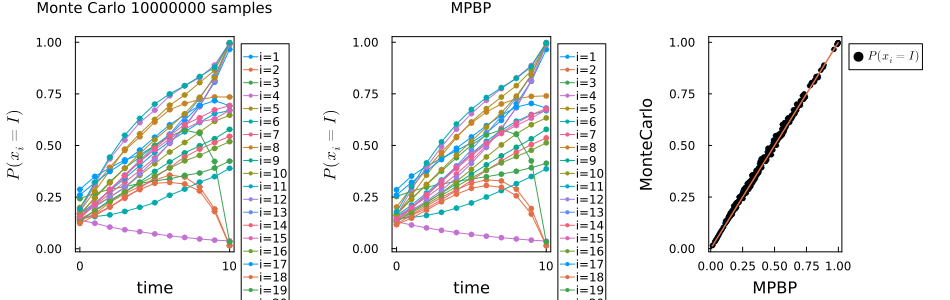

In [18]:
title = "Monte Carlo $(length(sms.X)) samples"
pl_mc = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:10:T, title=title)
for i in 1:N
    plot!(pl_mc, 0:T, p_mc[i], label="i=$i", m=:o, ms=3, lw=1, markerstrokecolor=:auto)
end
pl_bp = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:10:T, title="MPBP")
for i in 1:N
    plot!(pl_bp, 0:T, p_bp[i], label="i=$i", m=:o, ms=3, lw=1, markerstrokecolor=:auto)
end
pl_sc = scatter(reduce(vcat, p_bp), reduce(vcat, p_mc), xlabel="MPBP", ylabel="MonteCarlo", 
    label="\$P(x_i=I)\$", ms=3, c=:black, legend=:outertopright)
plot!(pl_sc, identity, label="", size=(300,300))
println("SIS on random graph N=$N. P(S→I)=$λ, P(I→S)=$ρ. P(zero patient)=", round(γ, digits=3))
println("$nobs random node observations at final time.")
println("Max matrix size: ", svd_trunc.mprime, "x", svd_trunc.mprime)
plot(pl_mc, pl_bp, pl_sc, titlefontsize=10, size=(950, 300), legend=:outertopright, 
    margin=5Plots.mm, layout=(1,3))

In [19]:
Plots.default(
    grid = :off, box = :on,
    legend = :topright,
    widen = true,
    label = "",
    lw = 1.5,
    msc = :auto,
    markersize = 2
)

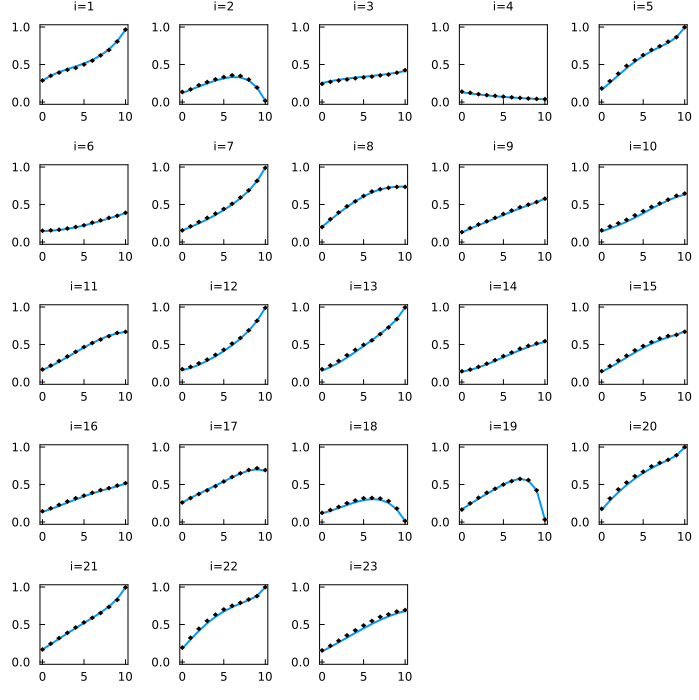

In [20]:
pls = Vector{Plots.Plot}(undef, N)
ylims=(0,1)
xticks=0:5:T; yticks=0:0.5:1
for i in 1:N
    pls[i] = plot(0:T, p_bp[i]; ylims, xticks, yticks, title="i=$i",
        titlefontsize=8, topmargin=0Plots.mm, c=:auto, lw=2)
    scatter!(pls[i], 0:T, p_mc[i], m=:diamond, c=:black, ms=2.5)
end
plot(pls..., layout=(5,5), size=(700,700))

In [13]:
# jldsave("plot_data/sis_softmargin.jld2"; T, N, p_bp, p_mc, observed_sites, ns);